# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [2]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [3]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,
    seed=None,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [4]:
simulator.camera_scopeview()

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [5]:
class Controller:
    def __init__(self, A, B, C, K, L, stars, dt = 0.04):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.dt = dt
        self.xhat = np.zeros(6)
        self.star_e = stars
        self.log = True

    
    def reset(self):
        pass
    
    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
        u = -self.K @ self.xhat

        y = star_measurements - self.star_e

        if self.log:
            print(y.tolist())
            self.log = False

        #y_hat = self.C @ self.xhat
        #dxhat = self.A @ self.xhat + self.B @ u + self.L @ (y - y_hat)
        #self.xhat += dxhat * self.dt 

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )
        
        torque_1, torque_2, torque_3, torque_4 = u*100
        #print(u)
        
        return torque_1, torque_2, torque_3, torque_4

Create an instance of the controller.

In [6]:

A = [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
B = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-0.018530635807362836, 0.037061271614725715, -0.018530635807362836, -2.62041779934909e-18], [-0.032096002714907576, -4.538696765530462e-18, 0.032096002714907576, 0.0], [-0.0249042741960589, -0.0249042741960589, -0.0249042741960589, 0.0498085483921178]]
C = [[-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, -0.532113843210265, 0.0, 0.0, 0.0], [-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, -0.263378514224308, 0.0, 0.0, 0.0], [-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, 0.532113843210265, 0.0, 0.0, 0.0], [-2.625, 0.0, 0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0], [-2.625, 0.0, -0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0]]
K = [[-0.5345224838248839, -0.9999999999998959, -0.5773502691894614, -3.7038955966791214, -6.415335359381055, -2.998241493413188], [-0.5345224838248145, -2.2632251145066475e-13, 1.1547005383792437, 7.407791193361367, -2.1269961010441337e-12, -2.998241493412767], [-0.5345224838248638, 1.0000000000001108, -0.577350269189834, -3.703895596682756, 6.415335359383099, -2.9982414934131163], [1.0690449676497082, 7.529866471687264e-15, 3.525923845504544e-14, 3.4471995660039383e-13, 5.5572610273729276e-14, 5.996482986826047]]

L = [[-0.008372184536939522, -3.2539340191363545e-17, -0.008122695129798898, -1.0772183148324961e-16, -0.008372184536939522, -3.3027201668317163e-16, -0.008041738574254458, -1.8885988420313028e-16, -0.00804173857425416, -1.8885988420313028e-16], [1.8885988420313028e-16, 0.007714169919606876, 1.8323189782339981e-16, 0.007909696932122763, 1.8885988420313028e-16, 0.008488482924702587, 0.00038715650254803736, 0.008434220930460022, -0.0003871565025476745, 0.008434220930460022], [7.645574030404231e-16, -0.01899975860613293, 7.417737469506759e-16, -0.008439678542012722, 7.645574030404231e-16, 0.02281956458245118, 0.02090966159429279, 0.001988383496538016, -0.02090966159429132, 0.001988383496538016], [1.1100846521748234e-17, -0.00044850220004810713, 1.0770043538936483e-17, -0.0002020333717530995, 1.1100846521748234e-17, 0.0005275471787251673, 0.00048802468938664785, 4.114652211659108e-05, -0.00048802468938662655, 4.114652211659108e-05], [5.2139970099531575e-18, 0.00043259203447232477, 5.0586209528313055e-18, 0.0004366381636817587, 5.2139970099531575e-18, 0.00044861524490677935, 8.011605217232296e-06, 0.0004587086418026459, -8.011605217222279e-06, 0.0004587086418026459], [-0.0004570774377193456, -2.8086134770737128e-18, -0.00044345662245293474, -8.357987779442536e-18, -0.0004570774377193456, -2.478487464517688e-17, -0.00043903681842071983, -1.4363671017417553e-17, -0.0004390368184206978, -1.4363671017417553e-17]]

A = np.array(A)
B = np.array(B)
C = np.array(C)
K = np.array(K)
L = np.array(L)

stars = [0.5321138432102653, 0.0, 0.2633785142243077, 0.0, -0.5321138432102653, 0.0, 0.0, 0.5321138432102653, 0.0, -0.5321138432102653]

controller = Controller(A,B,C,K,L,stars)

You could reset the simulator with given initial conditions.

In [7]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.1, #Test Recovory
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=20.        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.1$).

In [8]:
if False:
    simulator.reset(
        initial_conditions=None,
        scope_noise=0.1 ,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=False,      # <-- whether or not there is space debris
        docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )

Reset the controller.

In [9]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [10]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=25.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

[-0.03671865282266479, -0.0144928081443952, -0.008093237211410143, -0.08987105148136629, 0.014861625517583077, 0.027513460793261987, 0.012324555606535672, 0.06866288183110814, 0.17492095318801826, 0.03561033850369899]


Check if the space-cat has docked.

In [11]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat docked.


Get, show, and save a snapshot of the simulation after the last time step.

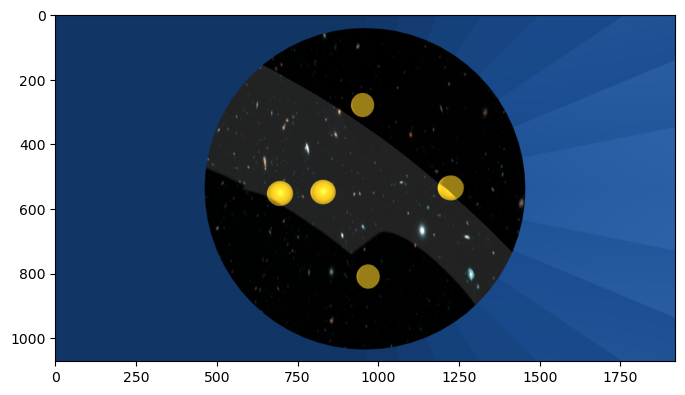

In [12]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

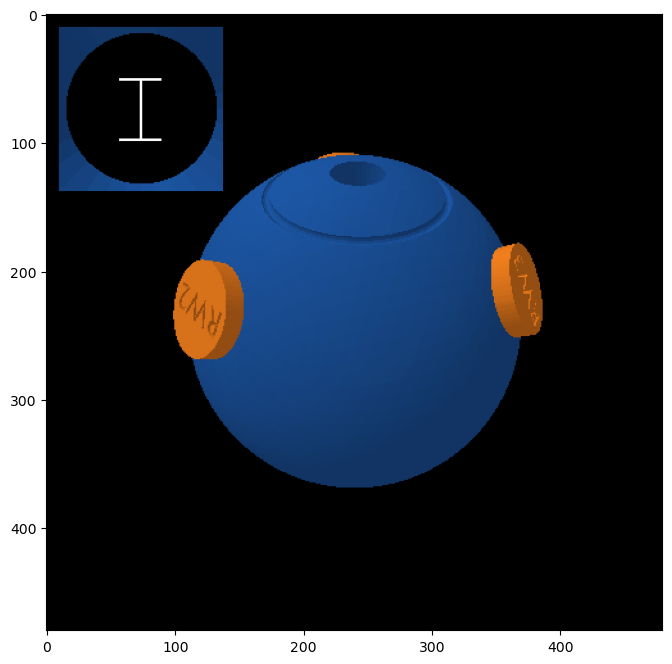

In [13]:
# Get snapshot as height x width x 4 numpy array of RGBA values
# with a picture-in-picture view of the scope
rgba = simulator.pybullet_snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

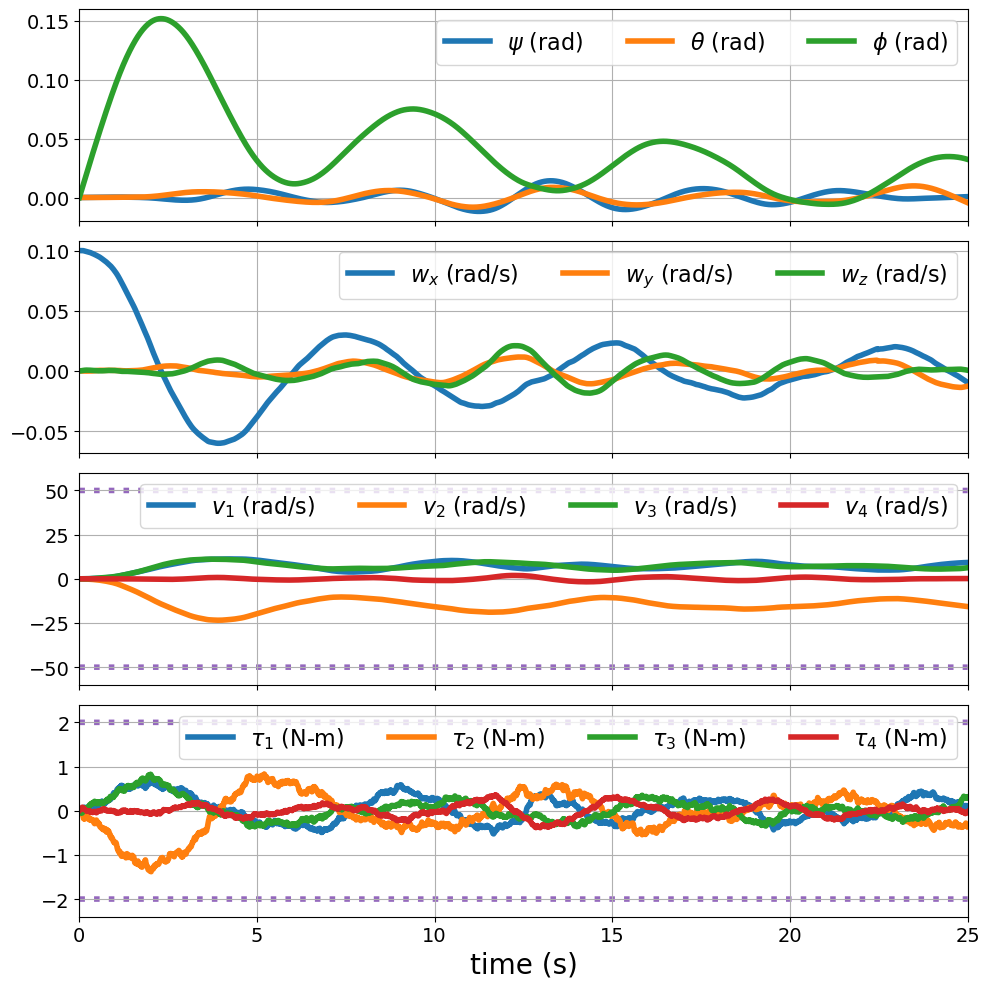

In [14]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)

ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [15]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

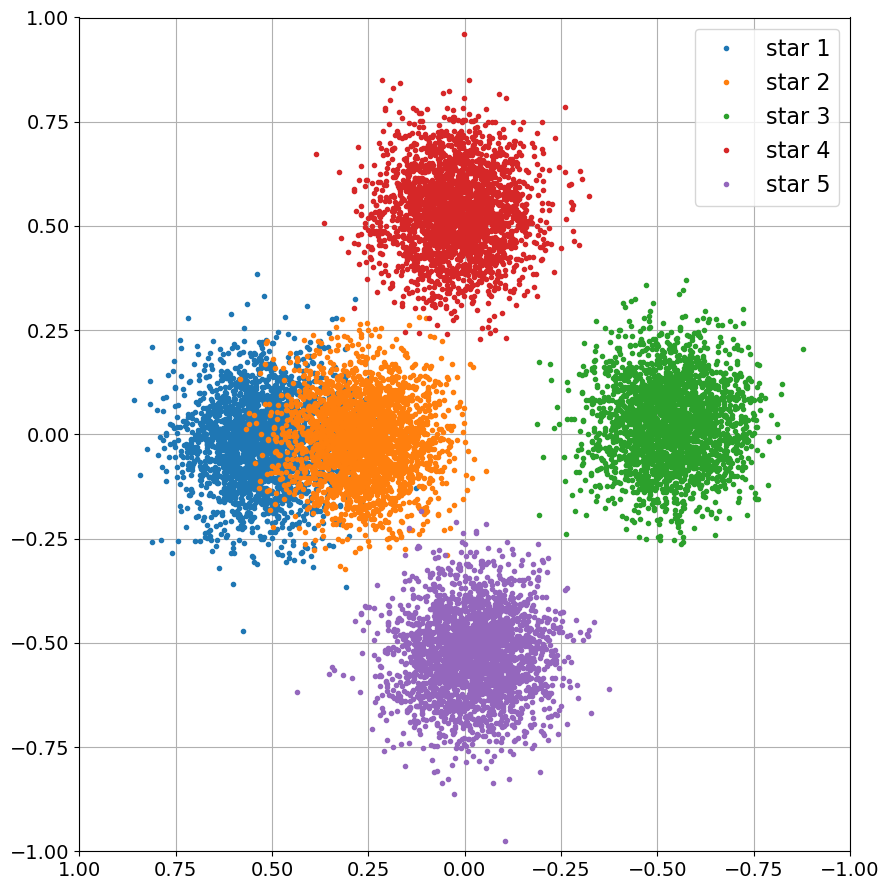

In [16]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()

In [17]:
simulator_f = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=None,
)

num_simulations = 0
successful_landings = 0
failed_landings = 0

for i in range(num_simulations):
    print("Sim:",i+1, "of", num_simulations)
    simulator_f.reset(
        initial_conditions=None,
        scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=True,      # <-- whether or not there is space debris
        docking_time=20.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )
    
    controller.reset()  # Reset controller
    
    # Run simulation
    data = simulator_f.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=20.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    
    # Check if the aircraft has landed
    if simulator_f.has_docked():
        successful_landings += 1
    else:
        failed_landings += 1

In [18]:
labels = ['Successful Dockings', 'Failed Dockings']
sizes = [successful_landings, failed_landings]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90,textprops={'fontsize': 14})
#plt.title('Docking Outcomes',fontsize=16)
plt.show()

c:\Users\jelly\miniconda3\envs\ae353\Lib\site-packages\matplotlib\axes\_axes.py:3343: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 600x600 with 1 Axes>